In [1]:
import glob
import pandas as pd
import numpy as np
import os
import plotnine as p9; p9.themes.theme_set(p9.theme_bw())

path = 'eval_results'

all_files = glob.glob(os.path.join(path , "*_summary.csv"))

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df['fn'] = filename
    li.append(df)

res_dt = pd.concat(li, axis=0, ignore_index=True)

# Find 'best' treatment AUTOC column for each row by finding highest T index that's not null
def return_max_treatment_index(row):
    for t in range(5,-1,-1):
        colname = f'AUTOC_val_t{t}'
        if colname in row and ~np.isnan(row[colname]):
            return t
    
res_dt['max_t_index'] = res_dt.apply(return_max_treatment_index, axis=1)

# Get AUTOC t values for max T index
def get_autoc_val(row, d):
    return(row[f'AUTOC_{d}_t{row.max_t_index}'])

def get_autoc_se_val(row, d):
    return(row[f'AUTOC_se_{d}_t{row.max_t_index}'])

res_dt['AUTOC_val'] = res_dt.apply(get_autoc_val, axis=1, d='val')
res_dt['AUTOC_se_val'] = res_dt.apply(get_autoc_se_val, axis=1, d='val')
res_dt['AUTOC_t_val'] = res_dt['AUTOC_val']/res_dt['AUTOC_se_val']
res_dt['AUTOC_val_lb'] = res_dt['AUTOC_val'] - 1.96*res_dt['AUTOC_se_val']
res_dt['AUTOC_val_ub'] = res_dt['AUTOC_val'] + 1.96*res_dt['AUTOC_se_val']


pd.set_option('display.max_columns', 50)

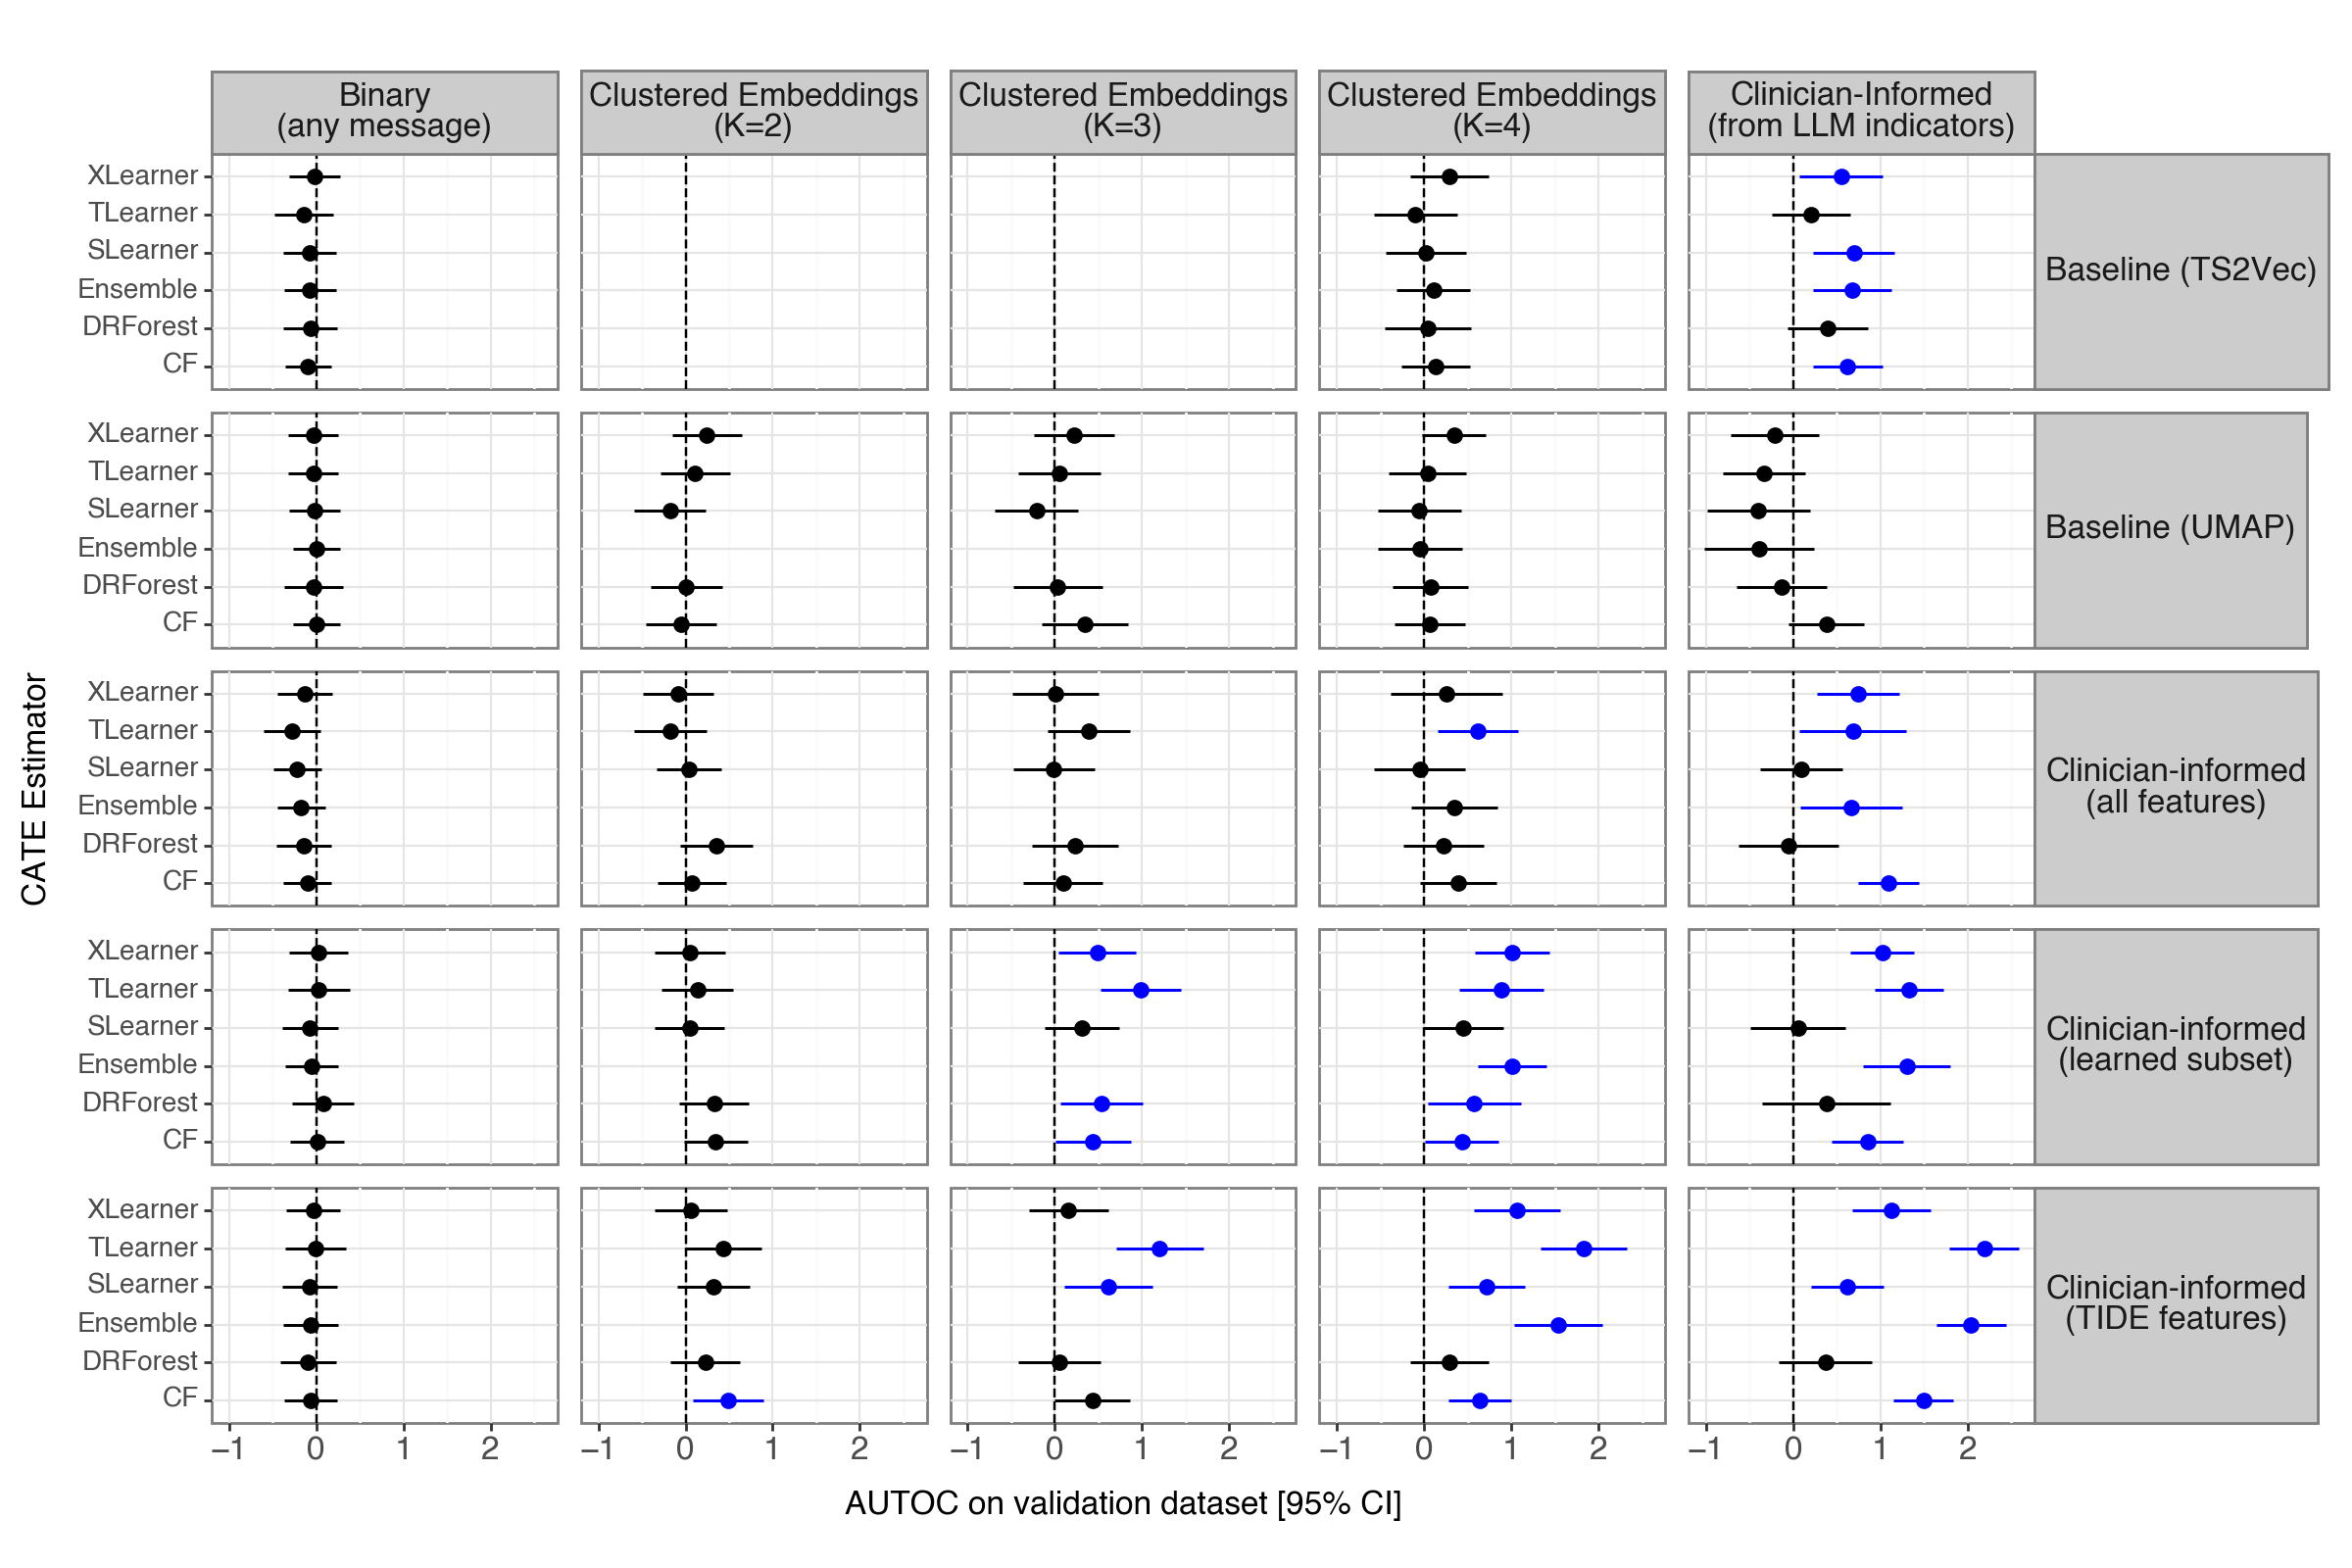

<Figure Size: (1200 x 800)>

In [11]:
# AUTOC curves renamed states and actions, for appendix

res_dt = res_dt.assign(autoc_color = np.where(res_dt.AUTOC_val_lb>0, 'blue', 'black'))
res_dt.loc[res_dt.AUTOC_val_ub<0, 'autoc_color'] = 'red'

action_map = {
    'Binary (any)': 'Binary\n(any message)',
    'Clustered Embeddings (2)': 'Clustered Embeddings\n(K=2)',    
    'Clustered Embeddings (3)': 'Clustered Embeddings\n(K=3)',    
    'Clustered Embeddings (4)': 'Clustered Embeddings\n(K=4)',
    'Expert v3': 'Clinician-Informed\n(from LLM indicators)',
}
res_dt['display_action_rep'] = res_dt.action_rep.map(action_map)

state_map = {
    'Raw (TS2Vec)': 'Baseline (TS2Vec)',
    'Raw (UMAP)': 'Baseline (UMAP)',
    'Expert (full)': 'Clinician-informed\n(all features)',
    'Expert (subset)': 'Clinician-informed\n(learned subset)',
    'TIDE': 'Clinician-informed\n(TIDE features)'
}
res_dt['display_state_rep'] = res_dt.state_rep.map(state_map)

# Reorder
res_dt['display_action_rep'] = pd.Categorical(res_dt['display_action_rep'], categories=list(action_map.values()), ordered=True)
res_dt['display_state_rep'] = pd.Categorical(res_dt['display_state_rep'], categories=list(state_map.values()), ordered=True)

p_autoc = (p9.ggplot(
    res_dt.query("(not display_state_rep.isna()) and (not display_action_rep.isna())"),
    p9.aes(x='cate_estimator', y='AUTOC_val*100', ymin='AUTOC_val_lb*100', ymax='AUTOC_val_ub*100', color='autoc_color')) + 
 p9.geom_pointrange(position=p9.position_dodge(0.6), size=0.6) + p9.geom_hline(yintercept=0, linetype='dashed') + p9.coord_flip() +
 p9.xlab('CATE Estimator') + p9.ylab('AUTOC on validation dataset [95% CI]') + p9.facet_grid('display_state_rep~display_action_rep') +
 p9.scale_color_identity() +
 p9.theme(
     figure_size=(12, 8),
     axis_text_x=p9.element_text(size=12),  # Customize x-axis text size and color
     axis_text_y=p9.element_text(size=10),  # Customize y-axis text size and color
     axis_title_x=p9.element_text(size=12),   # Customize x-axis title size and style
     axis_title_y=p9.element_text(size=12),   # Customize y-axis title size and style
     strip_text_y=p9.element_text(size=12, rotation=0),
     strip_text_x=p9.element_text(size=12)
 )
)
p_autoc

In [13]:
# Export as PDF
p_autoc.save(filename='figures/autocs.pdf', width=14, height=8, units='in', dpi=300)

/Users/johannes/anaconda3/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 14 x 8 in image.
/Users/johannes/anaconda3/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/autocs.pdf


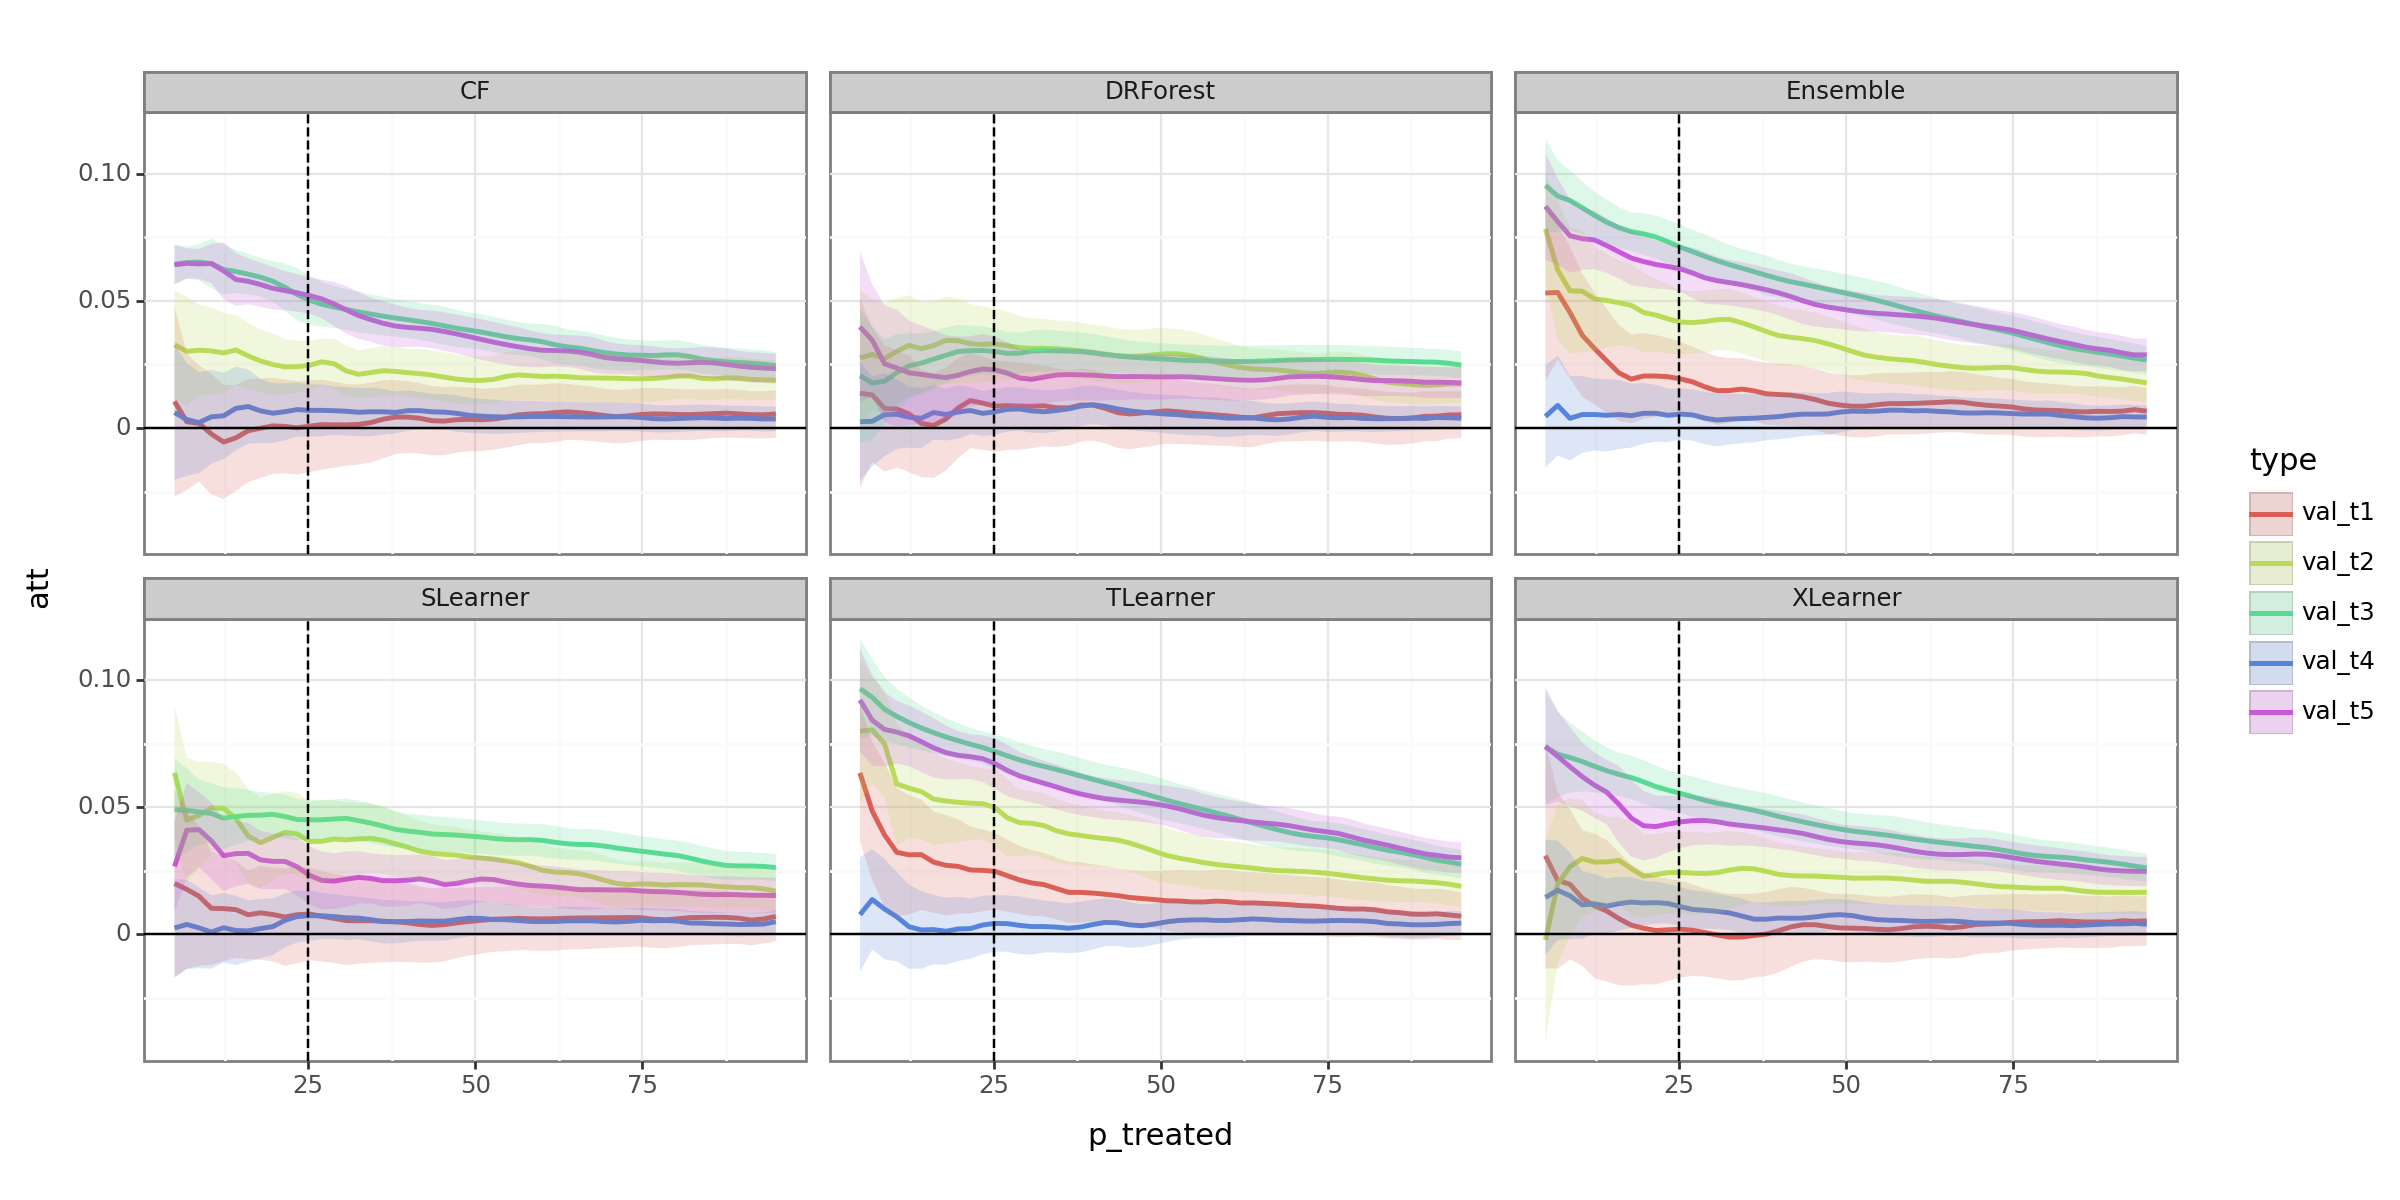

<Figure Size: (1200 x 600)>

In [51]:
# TOC Curves

all_files = glob.glob(os.path.join(path , "*_toc.csv"))

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

toc_dt = pd.concat(li, axis=0, ignore_index=True)


(p9.ggplot(
    toc_dt.query("(state_rep=='TIDE') and (action_rep=='Expert v3') and (dataset=='val')"),
    p9.aes(x='p_treated', y='att', ymin='att_lb', ymax='att_ub', color = 'type', fill='type')) + 
 p9.geom_line(size=1) + p9.geom_ribbon(alpha=0.2, size=0) +
 p9.facet_wrap("~cate_estimator", ncol=3) +
 p9.geom_hline(yintercept=0, linetype='solid') +
 p9.theme(figure_size=(12, 6)) + p9.geom_vline(xintercept=25, linetype='dashed')
)


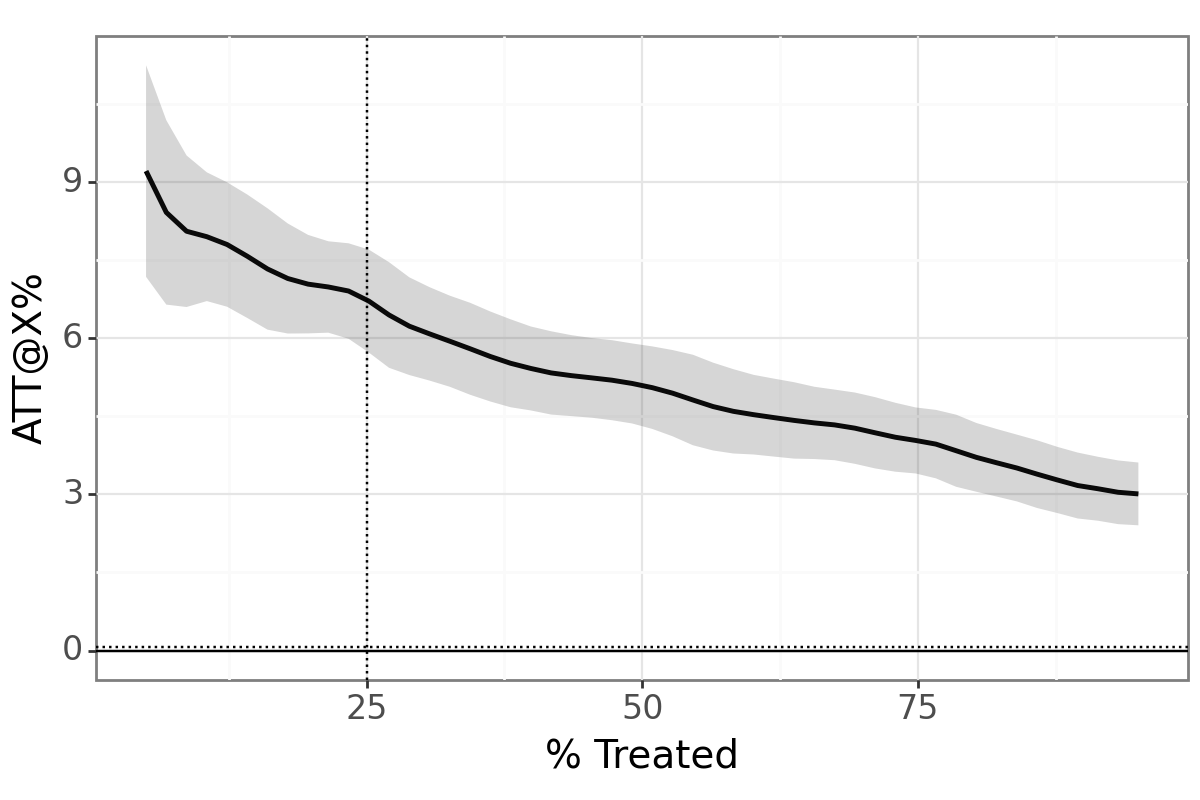

<Figure Size: (600 x 400)>

In [52]:
# Single curve
p = (p9.ggplot(
    toc_dt.query("(state_rep=='TIDE') and (action_rep=='Expert v3') and (dataset=='val') and (type=='val_t5') and (cate_estimator=='TLearner')"),
    p9.aes(x='p_treated', y='att*100', ymin='att_lb*100', ymax='att_ub*100')) + 
 p9.geom_line(size=1) + p9.geom_ribbon(alpha=0.2, size=0) +
 p9.geom_hline(yintercept=0, linetype='solid') +
 p9.geom_vline(xintercept=25, linetype='dotted') +
 p9.geom_hline(yintercept=0.067, linetype='dotted') + 
 p9.xlab("% Treated") + p9.ylab("ATT@X%") +
 p9.theme(
     figure_size=(6, 4),
     axis_text_x=p9.element_text(size=12),  # Customize x-axis text size and color
     axis_text_y=p9.element_text(size=12),  # Customize y-axis text size and color
     axis_title_x=p9.element_text(size=14),   # Customize x-axis title size and style
     axis_title_y=p9.element_text(size=14),   # Customize y-axis title size and style
 )
)
p

In [53]:
# Export as PDF
p.save(filename='figures/ex_toc.pdf', width=6, height=4, units='in', dpi=300)

/opt/conda/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 4 in image.
/opt/conda/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/ex_toc.pdf


# Calculate Policy Values,  i.e. ATT@25%

In [54]:
# Add new treatment column

toc_dt['action_name'] = ''

toc_dt.loc[toc_dt.action_rep == 'Expert v3', 'action_name'] = toc_dt[toc_dt.action_rep == 'Expert v3']['type'].map({
    'val_t1': 'Treat Highs & Lows',
    'val_t2': 'Treat Highs Only',
    'val_t3': 'Treat Lows Only',
    'val_t4': 'Other Message',
    'val_t5': 'Highest CATE Pred Action',
    'test_t1': 'Treat Highs & Lows',
    'test_t2': 'Treat Highs Only',
    'test_t3': 'Treat Lows Only',
    'test_t4': 'Other Message',
    'test_t5': 'Highest CATE Pred Action',
})

toc_dt.loc[toc_dt.action_rep == 'Clustered Embeddings (4)', 'action_name'] = toc_dt[toc_dt.action_rep == 'Clustered Embeddings (4)']['type'].map({
    'val_t1': 'Cluster 1',
    'val_t2': 'Cluster 2',
    'val_t3': 'Cluster 3',
    'val_t4': 'Cluster 4',
    'val_t5': 'Highest CATE Pred Action',
    'test_t1': 'Cluster 1',
    'test_t2': 'Cluster 2',
    'test_t3': 'Cluster 3',
    'test_t4': 'Cluster 4',
    'test_t5': 'Highest CATE Pred Action',
    
})

# Drop T1 for binary treatments
toc_dt = toc_dt[(toc_dt.action_rep != 'Binary (any)') | (toc_dt.type.isin(['val_t1','test_t1']))]

# Drop dose change only
toc_dt = toc_dt[toc_dt.action_rep != 'Binary (dose change)']

# Name binary action
toc_dt.loc[toc_dt.action_rep == 'Binary (any)', 'action_name'] = 'Highest CATE Pred Action'

In [55]:
# Calc ATE for each
ate_dt = toc_dt[toc_dt.p_treated==95.0].groupby(['action_rep','type','dataset','outcome','p_wins','prop_lb','action_name'])[['att','att_lb','att_ub']].mean().reset_index()
ate_dt = ate_dt.rename({
    'att': 'ate',
    'att_lb': 'ate_lb',
    'att_ub': 'ate_ub'
}, axis=1)

In [56]:
toc_dt_ate = toc_dt.merge(ate_dt, on=['action_rep','type','dataset','outcome','p_wins','prop_lb','action_name'])

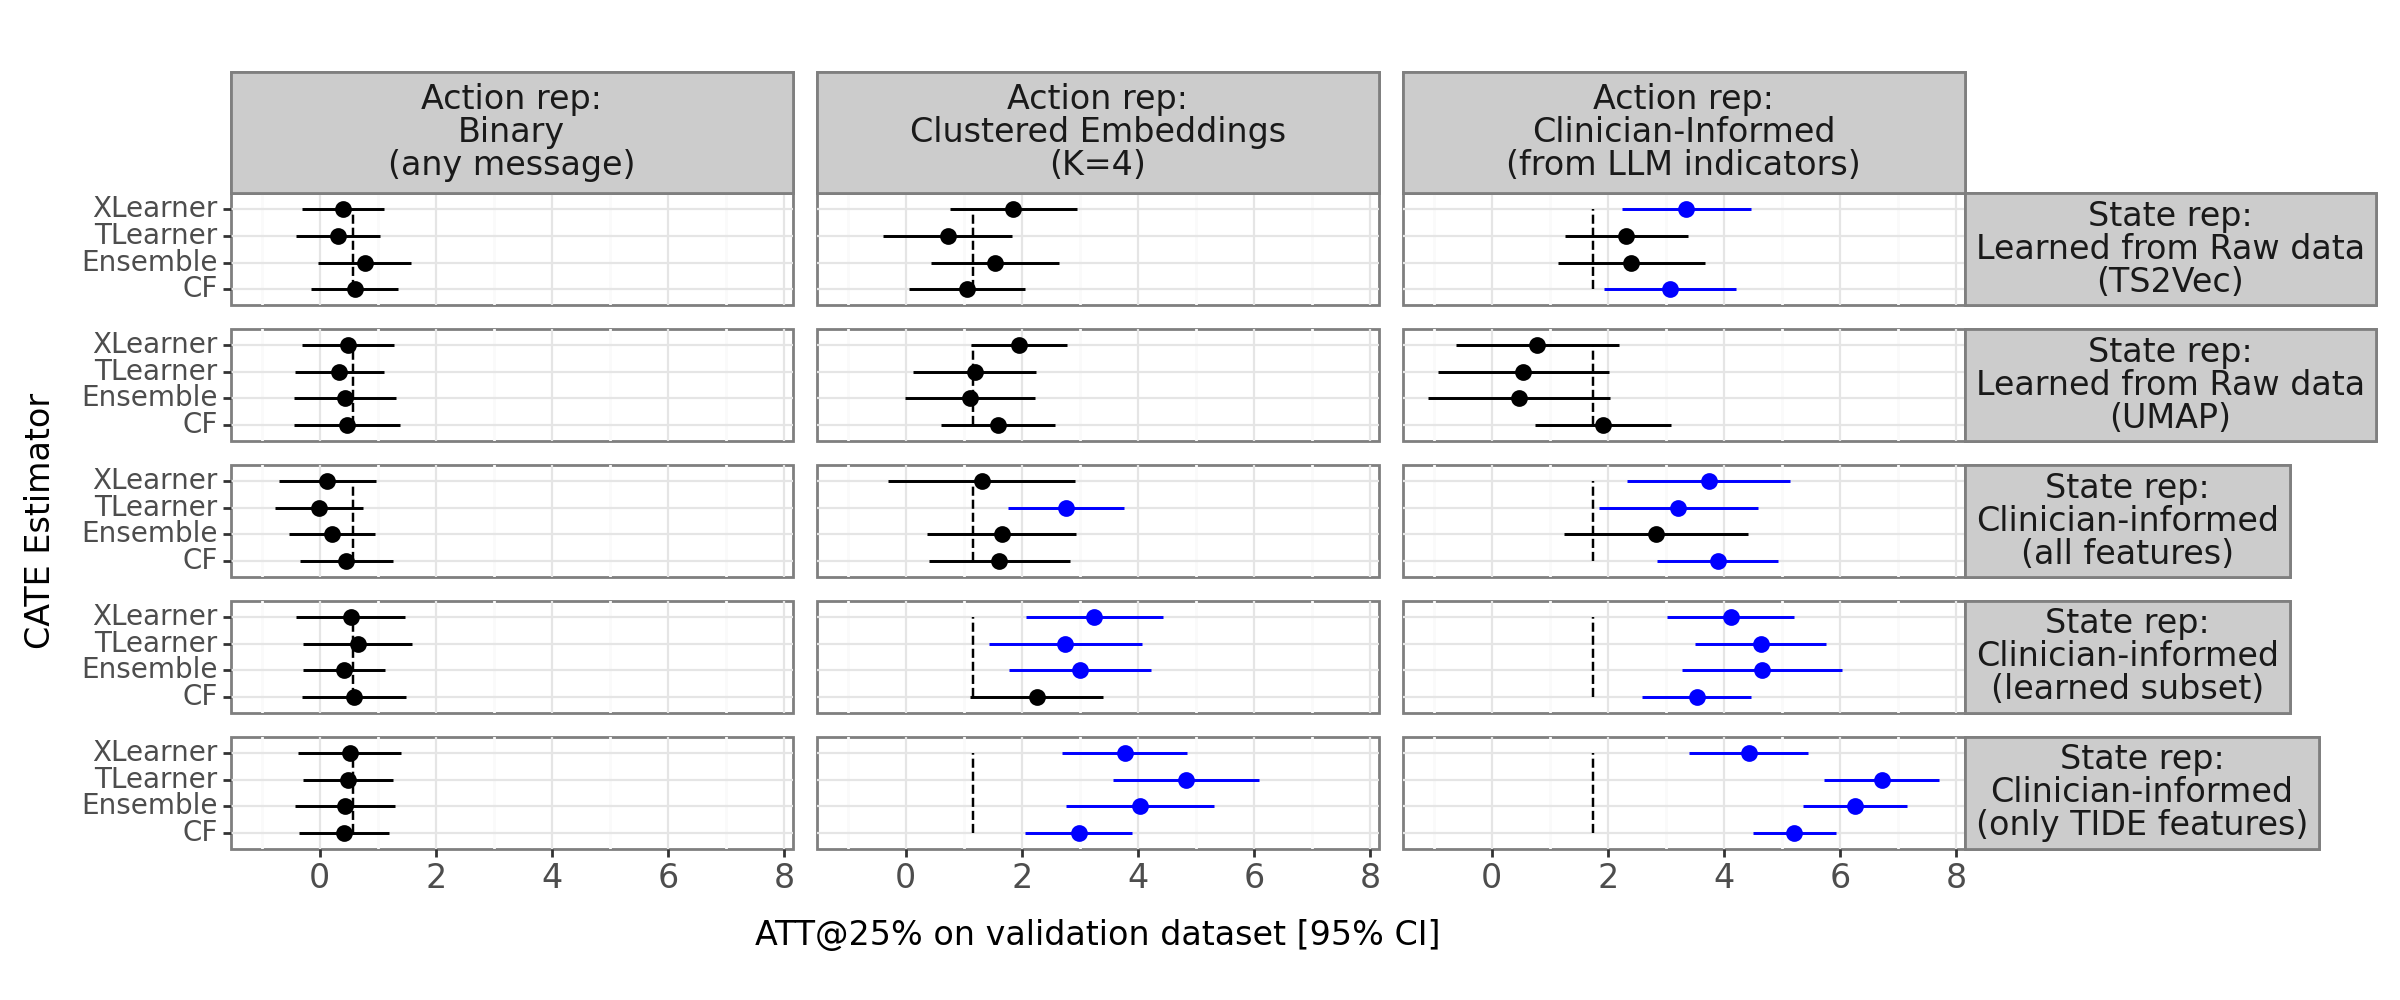

<Figure Size: (1200 x 500)>

In [75]:
# Create display names for representations

action_map = {
    'Binary (any)': 'Action rep:\nBinary\n(any message)',
    'Clustered Embeddings (4)': 'Action rep:\nClustered Embeddings\n(K=4)',
    'Expert v3': 'Action rep:\nClinician-Informed\n(from LLM indicators)',
}
toc_dt_ate['display_action_rep'] = toc_dt_ate.action_rep.map(action_map)

state_map = {
    'Raw (TS2Vec)': 'State rep:\nLearned from Raw data\n(TS2Vec)',
    'Raw (UMAP)': 'State rep:\nLearned from Raw data\n(UMAP)',
    'Expert (full)': 'State rep:\nClinician-informed\n(all features)',
    'Expert (subset)': 'State rep:\nClinician-informed\n(learned subset)',
    'TIDE': 'State rep:\nClinician-informed\n(only TIDE features)',
}
toc_dt_ate['display_state_rep'] = toc_dt_ate.state_rep.map(state_map)

# Reorder
toc_dt_ate['display_action_rep'] = pd.Categorical(toc_dt_ate['display_action_rep'], categories=list(action_map.values()), ordered=True)
toc_dt_ate['display_state_rep'] = pd.Categorical(toc_dt_ate['display_state_rep'], categories=list(state_map.values()), ordered=True)


# Color ATT@25% Lower bounds greater than ATE
toc_dt_ate = toc_dt_ate.assign(att25_color = np.where(toc_dt_ate.att_lb>toc_dt_ate.ate, 'blue', 'black'))

p = (p9.ggplot(
    toc_dt_ate.query("(p_treated>=24) and (p_treated<=26) and (dataset=='val') and \
        (action_rep in ('Binary (any)', 'Clustered Embeddings (4)','Expert v3')) and \
        (cate_estimator not in ('SLearner','DRForest')) and \
        (display_state_rep.notna()) and action_name == 'Highest CATE Pred Action'"), 
    p9.aes(x='cate_estimator', y='att*100', ymin='att_lb*100', ymax='att_ub*100', color='att25_color')) + 
 p9.geom_pointrange(position=p9.position_dodge(1), size=0.6) + 
 p9.coord_flip() +
 p9.ylab('ATT@25% on validation dataset [95% CI]') + 
 p9.facet_grid('display_state_rep~display_action_rep') +
 p9.stat_summary(p9.aes(y='ate*100', x='cate_estimator', group=1), fun_data = 'mean_se', geom = "line", color='black', size=0.5, linetype='dashed') + 
 p9.xlab("CATE Estimator") + p9.scale_color_identity() +
 p9.theme(
     figure_size=(12, 5),
     axis_text_x=p9.element_text(size=12),  # Customize x-axis text size and color
     axis_text_y=p9.element_text(size=10),  # Customize y-axis text size and color
     axis_title_x=p9.element_text(size=12),   # Customize x-axis title size and style
     axis_title_y=p9.element_text(size=12),   # Customize y-axis title size and style
     strip_text_y=p9.element_text(size=12, rotation=0),
     strip_text_x=p9.element_text(size=12)
 )
)

p

In [76]:
# Export as PDF
p.save(filename='figures/att25.pdf', width=11, height=6, units='in', dpi=300)

/opt/conda/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 11 x 6 in image.
/opt/conda/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/att25.pdf


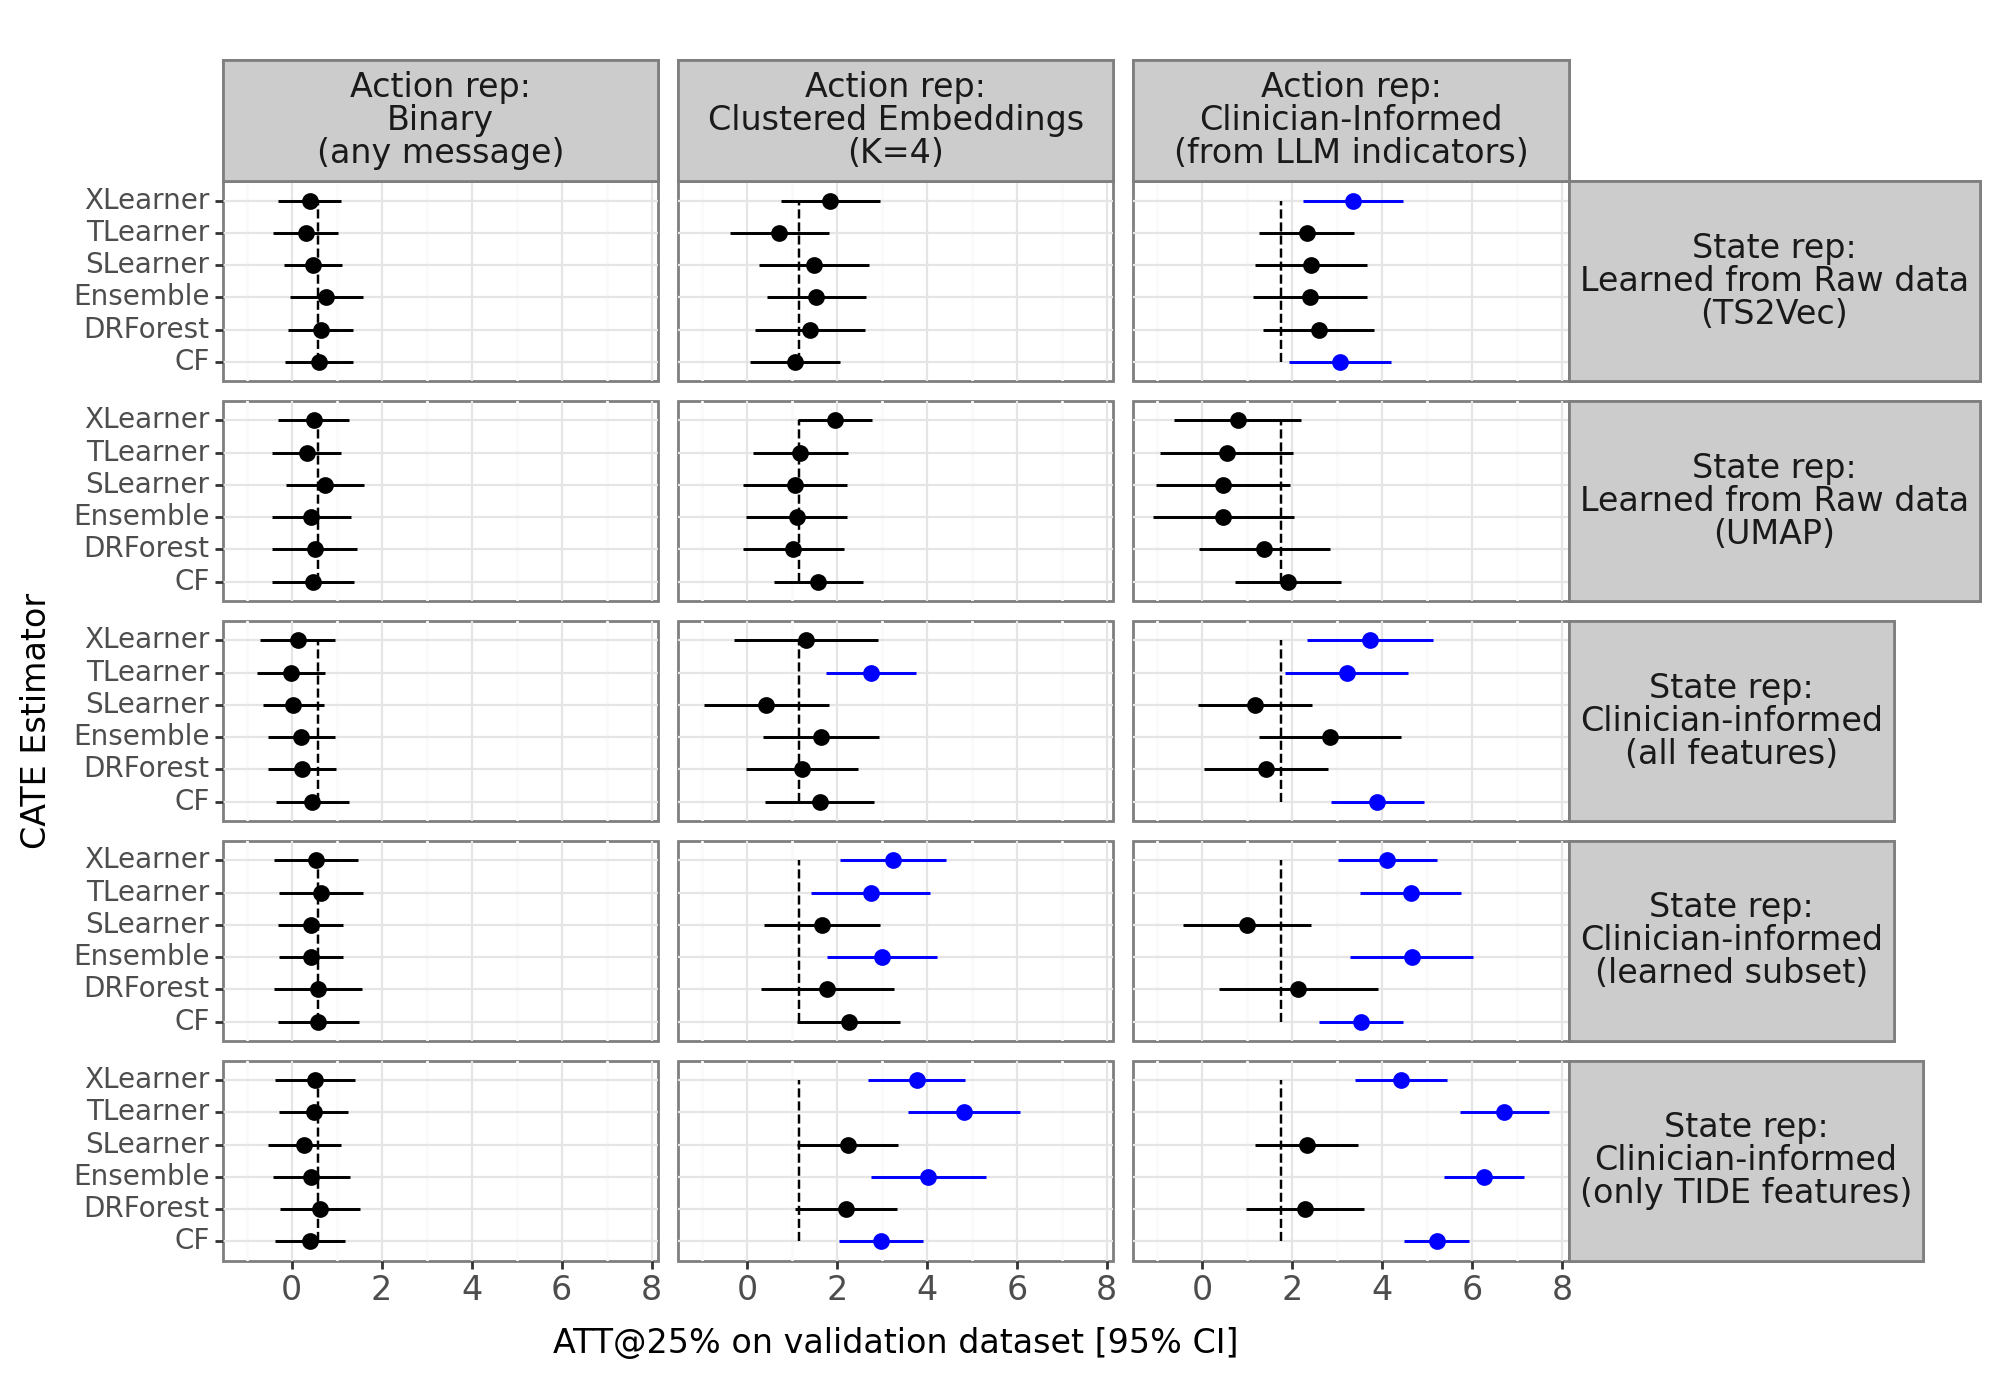

<Figure Size: (1000 x 700)>

In [77]:
# Full set with all CATE estimators

p_all_cate_est = (p9.ggplot(
    toc_dt_ate.query("(p_treated>=24) and (p_treated<=26) and (dataset=='val') and \
        (action_rep in ('Binary (any)', 'Clustered Embeddings (3)', 'Clustered Embeddings (4)','Expert v3')) and \
        (display_state_rep.notna()) and (display_action_rep.notna()) and (action_name == 'Highest CATE Pred Action')"),
    p9.aes(x='cate_estimator', y='att*100', ymin='att_lb*100', ymax='att_ub*100', color='att25_color')) + 
 p9.geom_pointrange(position=p9.position_dodge(1), size=0.6) + 
 p9.coord_flip() +
 p9.ylab('ATT@25% on validation dataset [95% CI]') + 
 p9.facet_grid('display_state_rep~display_action_rep') +
 p9.stat_summary(p9.aes(y='ate*100', x='cate_estimator', group=1), fun_data = 'mean_se', geom = "line", color='black', size=0.5, linetype='dashed') + 
 p9.xlab("CATE Estimator") + p9.scale_color_identity() +
 p9.theme(
     figure_size=(10, 7),
     axis_text_x=p9.element_text(size=12),  # Customize x-axis text size and color
     axis_text_y=p9.element_text(size=10),  # Customize y-axis text size and color
     axis_title_x=p9.element_text(size=12),   # Customize x-axis title size and style
     axis_title_y=p9.element_text(size=12),   # Customize y-axis title size and style
     strip_text_y=p9.element_text(size=12, rotation=0),
     strip_text_x=p9.element_text(size=12)
 )
)

p_all_cate_est

In [79]:
# Export as PDF
p.save(filename='figures/att25_all_cates.pdf', width=10, height=7, units='in', dpi=300)

/opt/conda/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 7 in image.
/opt/conda/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/att25_all_cates.pdf


# Sensitivity to more history in control covariates

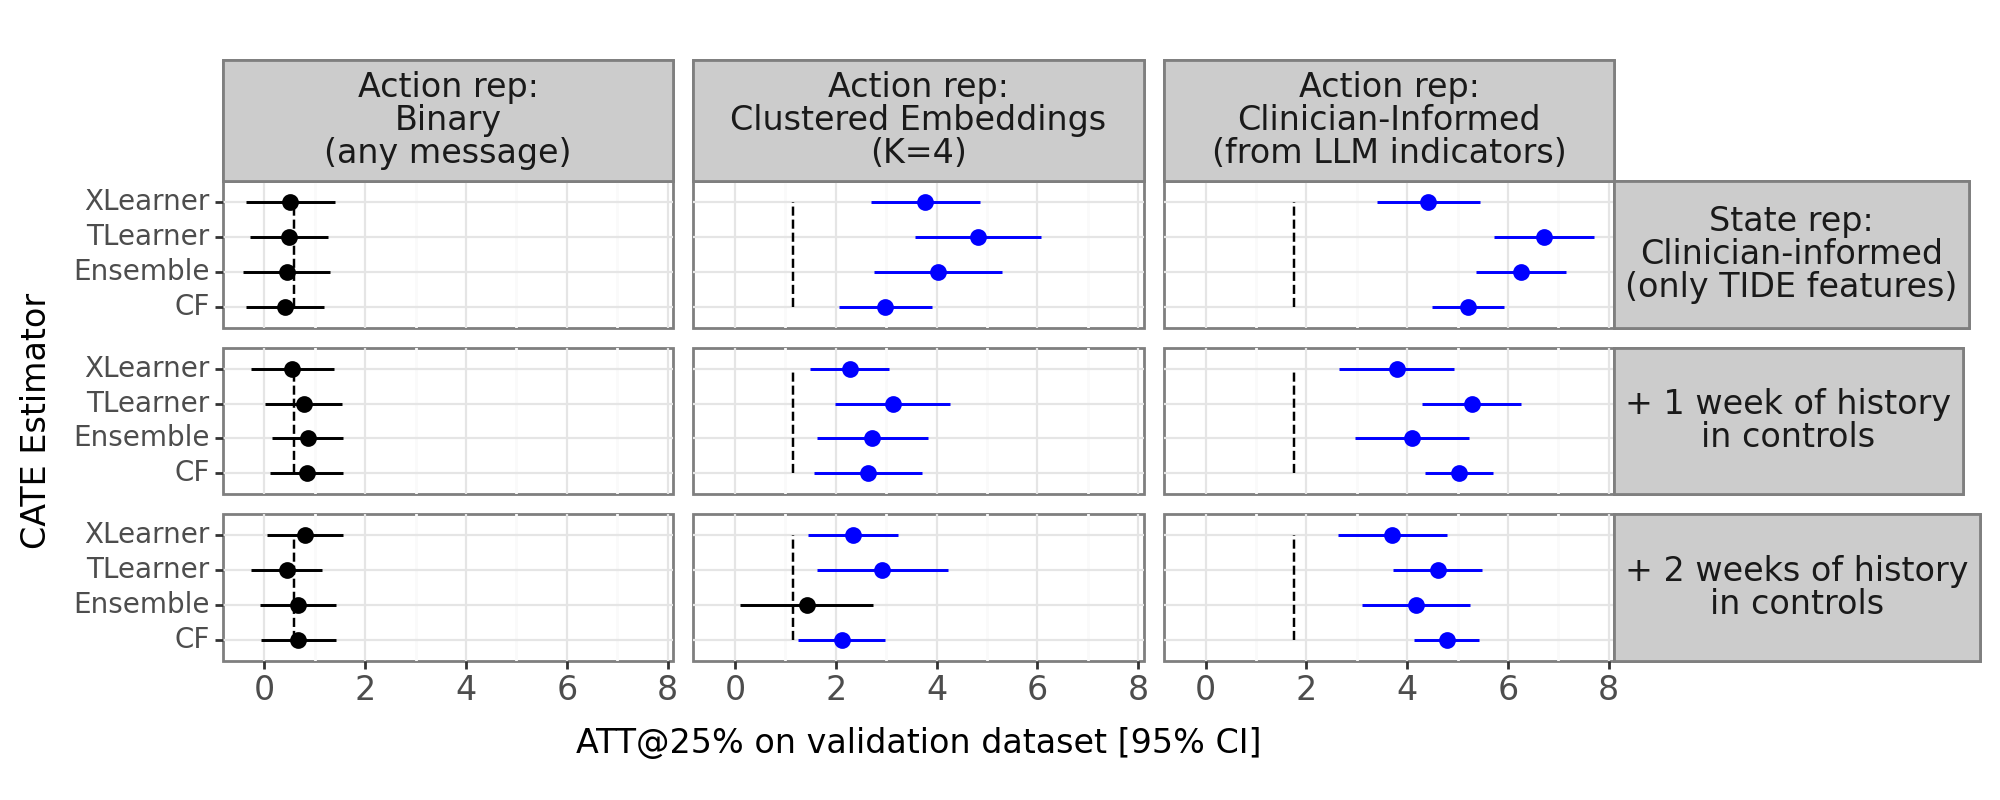

<Figure Size: (1000 x 400)>

In [80]:
# Create display names for representations

action_map = {
    'Binary (any)': 'Action rep:\nBinary\n(any message)',
    'Clustered Embeddings (4)': 'Action rep:\nClustered Embeddings\n(K=4)',
    'Expert v3': 'Action rep:\nClinician-Informed\n(from LLM indicators)',
}
toc_dt_ate['display_action_rep'] = toc_dt_ate.action_rep.map(action_map)

state_map = {
    'TIDE': 'State rep:\nClinician-informed\n(only TIDE features)',
    'TIDE (+1w lags in control covars)': '+ 1 week of history\nin controls',
    'TIDE (+2w lags in control covars)': '+ 2 weeks of history\nin controls',
}
toc_dt_ate['display_state_rep'] = toc_dt_ate.state_rep.map(state_map)

# Reorder
toc_dt_ate['display_action_rep'] = pd.Categorical(toc_dt_ate['display_action_rep'], categories=list(action_map.values()), ordered=True)
toc_dt_ate['display_state_rep'] = pd.Categorical(toc_dt_ate['display_state_rep'], categories=list(state_map.values()), ordered=True)


# Color ATT@25% Lower bounds greater than ATE
toc_dt_ate = toc_dt_ate.assign(att25_color = np.where(toc_dt_ate.att_lb>toc_dt_ate.ate, 'blue', 'black'))

p = (p9.ggplot(
    toc_dt_ate.query("(p_treated>=24) and (p_treated<=26) and (dataset=='val') and \
        (action_rep in ('Binary (any)', 'Clustered Embeddings (4)','Expert v3')) and \
        (cate_estimator not in ('SLearner','DRForest')) and \
        (display_state_rep.notna()) and action_name == 'Highest CATE Pred Action'"), # delta_in_range_fw_7d inv_delta_gri_fw_7d
    p9.aes(x='cate_estimator', y='att*100', ymin='att_lb*100', ymax='att_ub*100', color='att25_color')) + 
 p9.geom_pointrange(position=p9.position_dodge(1), size=0.6) + 
#  p9.geom_hline(yintercept=0, linetype='dashed') + 
 p9.coord_flip() +
 p9.ylab('ATT@25% on validation dataset [95% CI]') + 
 p9.facet_grid('display_state_rep~display_action_rep') +
 p9.stat_summary(p9.aes(y='ate*100', x='cate_estimator', group=1), fun_data = 'mean_se', geom = "line", color='black', size=0.5, linetype='dashed') + 
 p9.xlab("CATE Estimator") + p9.scale_color_identity() +
 p9.theme(
     figure_size=(10, 4),
     axis_text_x=p9.element_text(size=12),  # Customize x-axis text size and color
     axis_text_y=p9.element_text(size=10),  # Customize y-axis text size and color
     axis_title_x=p9.element_text(size=12),   # Customize x-axis title size and style
     axis_title_y=p9.element_text(size=12),   # Customize y-axis title size and style
     strip_text_y=p9.element_text(size=12, rotation=0),
     strip_text_x=p9.element_text(size=12)
 )
)

p

In [81]:
# Export as PDF
p.save(filename='figures/att25_sensitivity.pdf', width=10, height=4, units='in', dpi=300)

/opt/conda/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 4 in image.
/opt/conda/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/att25_sensitivity.pdf


# Test set eval for best policy
TIDE state rep. Clinician action rep (v3). T-Learner

In [ ]:
toc_dt_ate.query("(p_treated>=24) and (p_treated<=26) and  \
        (action_rep == 'Expert v3') and  (state_rep=='TIDE') and cate_estimator=='TLearner' and \
        (display_state_rep.notna()) and action_name == 'Highest CATE Pred Action'")

,p_treated,toc,toc_std,toc_lb,toc_ub,att,att_lb,att_ub,type,dataset,outcome,state_rep,action_rep,cate_estimator,p_wins,prop_lb,action_name,ate,ate_lb,ate_ub,display_action_rep,display_state_rep,att25_color
4059,25.204082,0.039306,0.004390,0.030701,0.047911,0.067157,0.057270,0.077045,val_t5,val,delta_in_range_fw_7d,TIDE,Expert v3,TLearner,0.05,0.01,Highest CATE Pred Action,0.017491,0.011612,0.023370,Action rep:\nClinician-Informed\n(from LLM ind...,State rep:\nClinician-informed\n(only TIDE fea...,blue
4309,25.204082,0.036103,0.004444,0.027392,0.044813,0.065854,0.056007,0.075701,test_t5,test,delta_in_range_fw_7d,TIDE,Expert v3,TLearner,0.05,0.01,Highest CATE Pred Action,0.022757,0.016169,0.029345,Action rep:\nClinician-Informed\n(from LLM ind...,State rep:\nClinician-informed\n(only TIDE fea...,blue
